이상치 탐지 및 제거

탐지된 이상치 학생 수: 3명 (5.1%)

이상치 학생 목록:
                      id studentGrade  totalScore  불안 및 우울 문제  심리외상 문제  외현화 문제  자살 및 위기 문제  학교생활적응 문제
0   -ORO3afb_TN98Kofxvo2          2학년          80          24       14       9          18         15
7   -ORO6JSmibg774hAc5yk          1학년          39          13        7       3           8          8
44  -OROHGqFqUxw7P-2ZX8D          1학년          73          12       15      21          14         11


C:\Users\user\AppData\Local\Temp\ipykernel_10272\3281471651.py:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(),


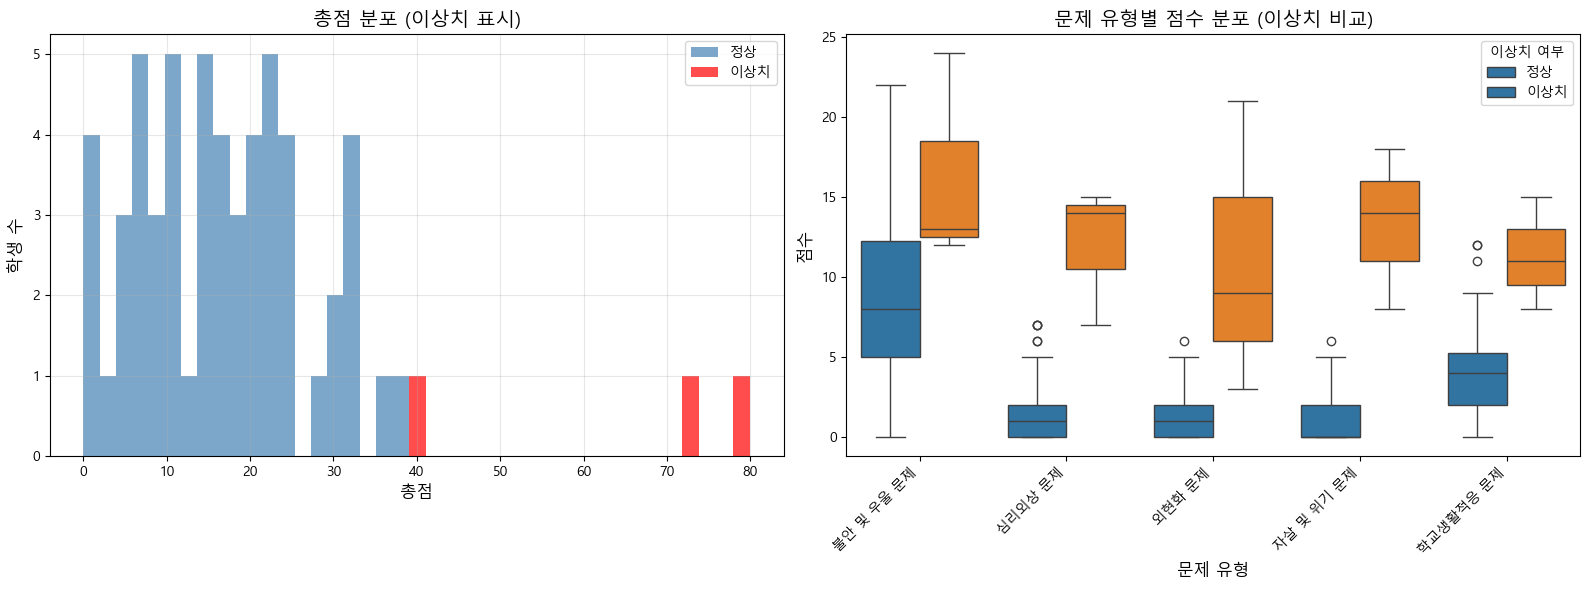


이상치 제거 후 학생 수: 56명

최적 클러스터 수 탐지 중... (이상치 제거 후)


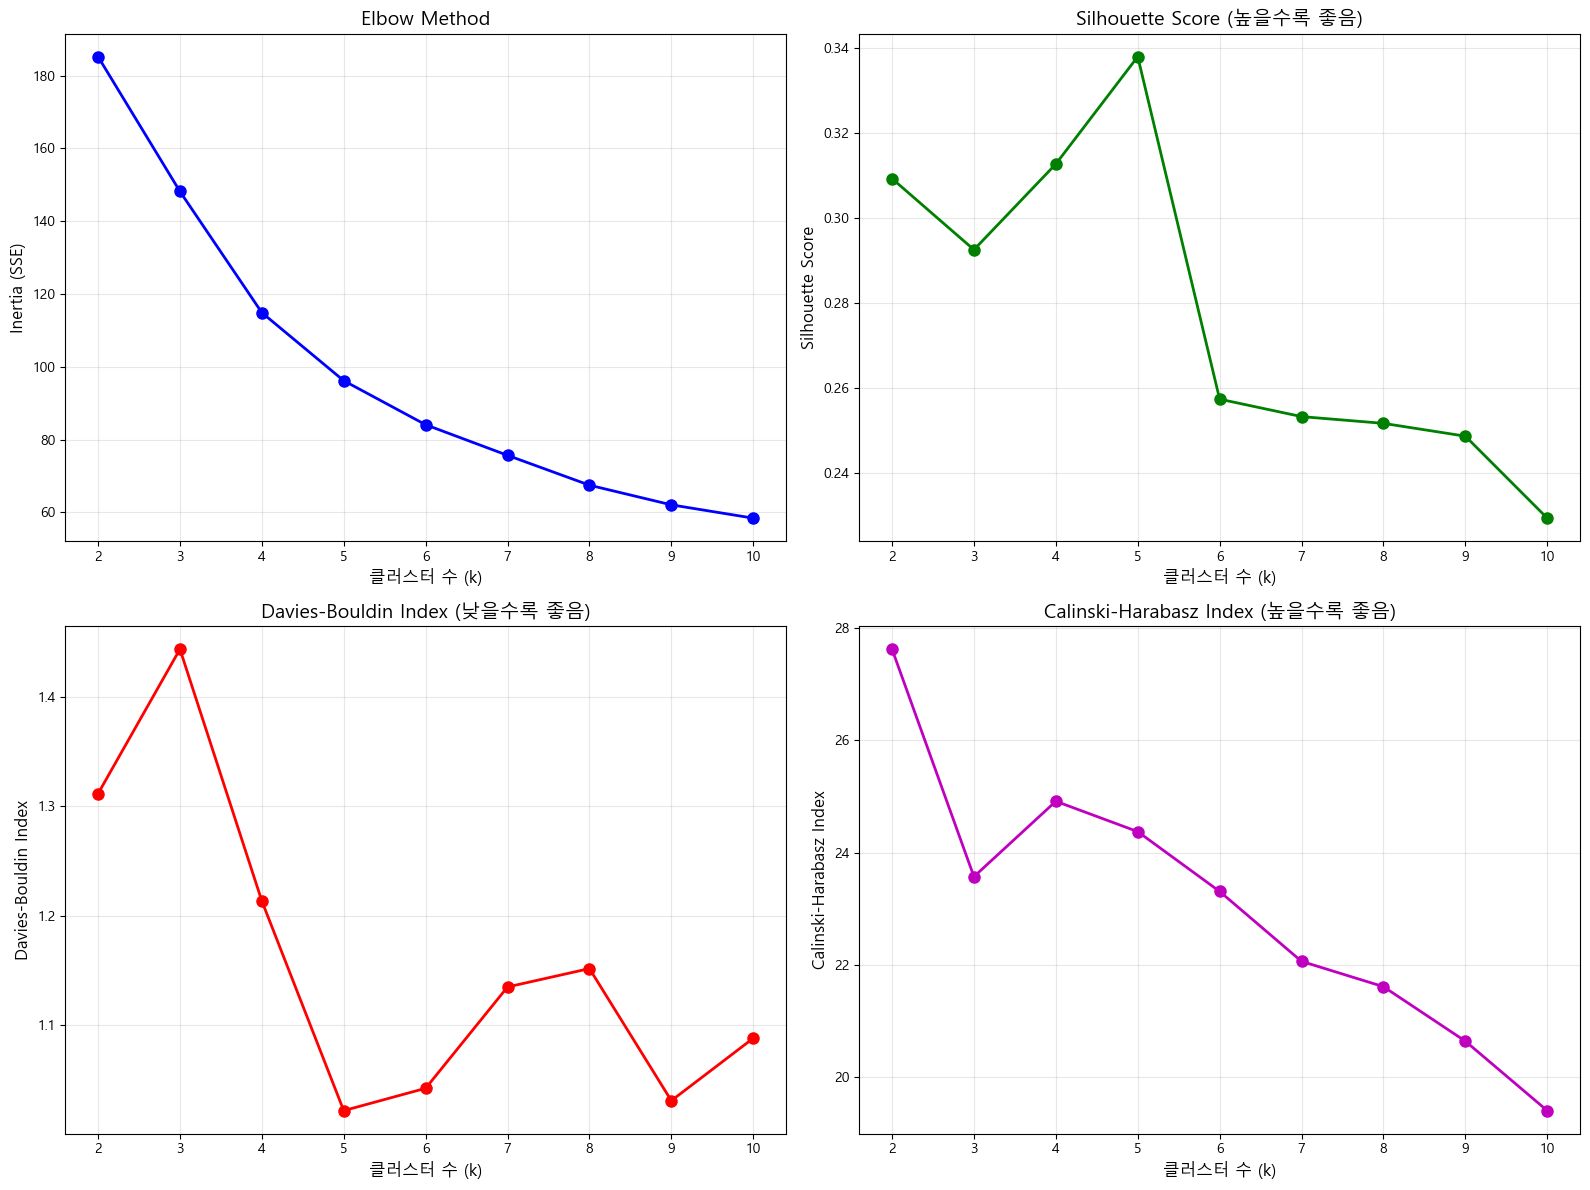


최적 클러스터 수: 5
  - Silhouette Score: 0.338
  - Davies-Bouldin Index: 1.022
  - Calinski-Harabasz Index: 24.374

클러스터별 학생 수:
cluster
0    14
1     6
2    23
3     6
4     7
Name: count, dtype: int64

클러스터별 특성 요약
        불안 및 우울 문제                   심리외상 문제                    외현화 문제  \
              mean       std count      mean       std count      mean   
cluster                                                                  
0         9.857143  3.034599    14  2.142857  1.460092    14  3.428571   
1        14.666667  2.581989     6  6.333333  0.816497     6  1.666667   
2         3.695652  2.819329    23  0.347826  0.647281    23  0.521739   
3        16.500000  3.563706     6  0.500000  0.836660     6  0.500000   
4         9.142857  4.220133     7  0.714286  0.951190     7  1.000000   

                        자살 및 위기 문제                 학교생활적응 문제                  \
              std count       mean       std count      mean       std count   
cluster                              

In [2]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_classif
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.ensemble import IsolationForest
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Load data
file = open('./input/data.json', 'r', encoding='utf-8')
data = json.load(file)

mpl.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['axes.unicode_minus'] = False

students_data = data['students']

rows = []
for student_id, info in students_data.items():
    row = info['scores']
    row['studentGrade'] = info['studentGrade']
    row['totalScore'] = info['totalScore']
    row['id'] = student_id
    rows.append(row)

df = pd.DataFrame(rows)
df['grade_num'] = df['studentGrade'].str.extract(r'(\d)').astype(int)

features = ['불안 및 우울 문제', '심리외상 문제', '외현화 문제', '자살 및 위기 문제', '학교생활적응 문제']

# ==========================================
# 이상치 탐지 및 제거
# ==========================================
print("="*80)
print("이상치 탐지 및 제거")
print("="*80)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# Isolation Forest로 이상치 탐지
iso_forest = IsolationForest(
    contamination=0.05, random_state=42)  # 상위 5%를 이상치로 간주
outlier_labels = iso_forest.fit_predict(X_scaled)

# 이상치 정보 출력
df['is_outlier'] = outlier_labels == -1
outliers = df[df['is_outlier']]

print(f"\n탐지된 이상치 학생 수: {len(outliers)}명 ({len(outliers)/len(df)*100:.1f}%)")
print("\n이상치 학생 목록:")
print(outliers[['id', 'studentGrade', 'totalScore'] + features].to_string())

# 이상치 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 총점 분포
axes[0].hist(df[~df['is_outlier']]['totalScore'], bins=20,
             alpha=0.7, label='정상', color='steelblue')
axes[0].hist(df[df['is_outlier']]['totalScore'], bins=20,
             alpha=0.7, label='이상치', color='red')
axes[0].set_xlabel('총점', fontsize=12, fontfamily='Malgun Gothic')
axes[0].set_ylabel('학생 수', fontsize=12, fontfamily='Malgun Gothic')
axes[0].set_title('총점 분포 (이상치 표시)', fontsize=14, fontfamily='Malgun Gothic')
axes[0].legend(prop={'family': 'Malgun Gothic'})
axes[0].grid(True, alpha=0.3)

# 박스플롯으로 이상치 확인
df_melted = df.melt(id_vars=['is_outlier'], value_vars=features,
                    var_name='문제유형', value_name='점수')
sns.boxplot(data=df_melted, x='문제유형', y='점수', hue='is_outlier', ax=axes[1])
axes[1].set_xlabel('문제 유형', fontsize=12, fontfamily='Malgun Gothic')
axes[1].set_ylabel('점수', fontsize=12, fontfamily='Malgun Gothic')
axes[1].set_title('문제 유형별 점수 분포 (이상치 비교)', fontsize=14,
                  fontfamily='Malgun Gothic')
axes[1].set_xticklabels(axes[1].get_xticklabels(),
                        rotation=45, ha='right', fontfamily='Malgun Gothic')
axes[1].legend(title='이상치 여부', labels=['정상', '이상치'],
               prop={'family': 'Malgun Gothic'})

plt.tight_layout()
plt.show()

# 이상치 제거
df_filtered = df[~df['is_outlier']].copy()
X_scaled_filtered = scaler.fit_transform(df_filtered[features])

print(f"\n이상치 제거 후 학생 수: {len(df_filtered)}명")

# ==========================================
# 1. 최적 클러스터 수 자동 탐지 (이상치 제거 후)
# ==========================================
print("\n" + "="*80)
print("최적 클러스터 수 탐지 중... (이상치 제거 후)")
print("="*80)

k_range = range(2, 11)
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []
inertias = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled_filtered)

    silhouette_scores.append(silhouette_score(X_scaled_filtered, labels))
    davies_bouldin_scores.append(
        davies_bouldin_score(X_scaled_filtered, labels))
    calinski_harabasz_scores.append(
        calinski_harabasz_score(X_scaled_filtered, labels))
    inertias.append(kmeans.inertia_)

# 시각화
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('클러스터 수 (k)', fontsize=12, fontfamily='Malgun Gothic')
axes[0, 0].set_ylabel('Inertia (SSE)', fontsize=12, fontfamily='Malgun Gothic')
axes[0, 0].set_title('Elbow Method', fontsize=14, fontfamily='Malgun Gothic')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('클러스터 수 (k)', fontsize=12, fontfamily='Malgun Gothic')
axes[0, 1].set_ylabel('Silhouette Score', fontsize=12,
                      fontfamily='Malgun Gothic')
axes[0, 1].set_title('Silhouette Score (높을수록 좋음)',
                     fontsize=14, fontfamily='Malgun Gothic')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(k_range, davies_bouldin_scores,
                'ro-', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('클러스터 수 (k)', fontsize=12, fontfamily='Malgun Gothic')
axes[1, 0].set_ylabel('Davies-Bouldin Index', fontsize=12,
                      fontfamily='Malgun Gothic')
axes[1, 0].set_title('Davies-Bouldin Index (낮을수록 좋음)',
                     fontsize=14, fontfamily='Malgun Gothic')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(k_range, calinski_harabasz_scores,
                'mo-', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('클러스터 수 (k)', fontsize=12, fontfamily='Malgun Gothic')
axes[1, 1].set_ylabel('Calinski-Harabasz Index',
                      fontsize=12, fontfamily='Malgun Gothic')
axes[1, 1].set_title('Calinski-Harabasz Index (높을수록 좋음)',
                     fontsize=14, fontfamily='Malgun Gothic')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 최적 k 결정
normalized_silhouette = (np.array(silhouette_scores) - np.min(silhouette_scores)
                         ) / (np.max(silhouette_scores) - np.min(silhouette_scores))
normalized_db = 1 - (np.array(davies_bouldin_scores) - np.min(davies_bouldin_scores)
                     ) / (np.max(davies_bouldin_scores) - np.min(davies_bouldin_scores))
normalized_ch = (np.array(calinski_harabasz_scores) - np.min(calinski_harabasz_scores)
                 ) / (np.max(calinski_harabasz_scores) - np.min(calinski_harabasz_scores))

combined_score = normalized_silhouette + normalized_db + normalized_ch
optimal_k = list(k_range)[np.argmax(combined_score)]

print(f"\n최적 클러스터 수: {optimal_k}")
print(f"  - Silhouette Score: {silhouette_scores[optimal_k-2]:.3f}")
print(f"  - Davies-Bouldin Index: {davies_bouldin_scores[optimal_k-2]:.3f}")
print(
    f"  - Calinski-Harabasz Index: {calinski_harabasz_scores[optimal_k-2]:.3f}")

# ==========================================
# 2. 최적 k로 클러스터링 수행
# ==========================================
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_filtered['cluster'] = kmeans_optimal.fit_predict(X_scaled_filtered)

print(f"\n클러스터별 학생 수:")
cluster_counts = df_filtered['cluster'].value_counts().sort_index()
print(cluster_counts)

# 클러스터 크기가 너무 작은 것 확인
min_cluster_size = 5  # 최소 클러스터 크기
small_clusters = cluster_counts[cluster_counts < min_cluster_size]
if len(small_clusters) > 0:
    print(
        f"\n⚠️ 경고: {len(small_clusters)}개 클러스터의 학생 수가 {min_cluster_size}명 미만입니다.")
    print("더 적은 클러스터 수를 고려하거나 이상치 탐지 파라미터를 조정하세요.")

# 나머지 코드는 동일 (클러스터 프로파일 분석 등)
# ==========================================
# 3. 클러스터 프로파일 분석
# ==========================================
print("\n" + "="*80)
print("클러스터별 특성 요약")
print("="*80)

cluster_summary = df_filtered.groupby(
    'cluster')[features + ['totalScore']].agg(['mean', 'std', 'count'])
print(cluster_summary)

# 클러스터 센터
cluster_centers = scaler.inverse_transform(kmeans_optimal.cluster_centers_)
cluster_centers_df = pd.DataFrame(cluster_centers, columns=features)
cluster_centers_df.index.name = 'cluster'

print("\n클러스터 중심값:")
print(cluster_centers_df.round(2))

# 시각화는 이전과 동일...
# (Radar chart, Heatmap, Feature Importance, PCA 등)

In [17]:
from sklearn.feature_selection import f_classif
question_cols = [c for c in df.columns
                 if c not in ['id', 'studentGrade', 'totalScore', 'grade_num', 'is_outlier', 'cluster']]


Xq = df_filtered[question_cols]
yq = df_filtered['cluster']

f_vals, p_vals = f_classif(Xq, yq)

question_importance = pd.DataFrame({
    'question': question_cols,
    'F_value': f_vals,
    'p_value': p_vals
}).sort_values('F_value', ascending=False)

print(question_importance.head(10))

     question    F_value       p_value
1     심리외상 문제  48.416516  9.129129e-17
3  자살 및 위기 문제  33.074774  1.319367e-13
0  불안 및 우울 문제  29.980657  7.636818e-13
2      외현화 문제  17.962506  2.922456e-09
4   학교생활적응 문제  11.909744  6.594177e-07
